In [1]:
import os, math
from collections import defaultdict, namedtuple, deque
import dataclasses
from dataclasses import dataclass
import itertools
from enum import StrEnum, auto
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from module.utils import *
from module.hdc import *
from module.constants import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()
mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, fork method leads to failures in bootstrap somewhere around CUDA

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

hdc = Hdc(10_000, xp)

xp = numpy


In [3]:
%run sequencing_sp2.ipynb

# Open DB

In [4]:
%time
train_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.train_db_file_name))
test_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_db_file_name))
test_results_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_results_db_file_name, with_prefix=False), autocommit=True)

if not DBUtils.is_table_exists(test_results_db_con, 'test_runs'):
    test_results_db_con.execute('CREATE TABLE test_runs(test_run_id INTEGER PRIMARY KEY, dummy)')

df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 3.1 μs


((100, 9), (20, 9))


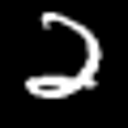
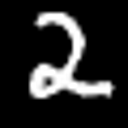
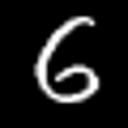
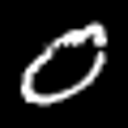
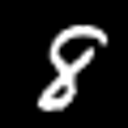
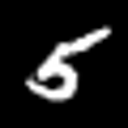
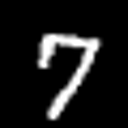
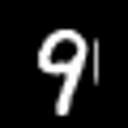
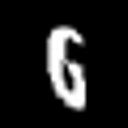
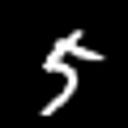
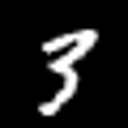
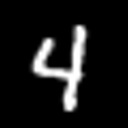
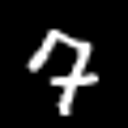
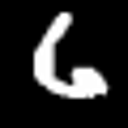
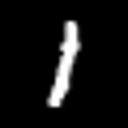
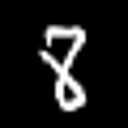

In [5]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

## Types

In [6]:
SeqLatentVecMeta = namedtuple('SeqLatentVec', ['engram_id', 'phase', 'seq', 'seq_lv_ind'])
Engram = namedtuple('Engram', ['engram_id', 'image_id', 'value', 'seq_lv_inds', 'si_ind_dict'])
# Matchee = namedtuple('Matchee', ['seqs', 'seq_lvs', 'seq_lv_codes', 'si_ind_dict'])
# Matchee = namedtuple('Matchee', ['seqs', 'seq_lvs_cos_sim', 'seq_lvs_corr', 'seq_lvs_diff_sq', 'seq_lv_codes', 'si_ind_dict'])
Matchee = namedtuple('Matchee', ['seqs', 'seq_lvs_cos_sim', 'seq_lvs_diff_sq', 'seq_lv_codes', 'si_ind_dict'])

## memory

In [7]:
SEQ_LV_LEN = 1000
#SEQ_LVS = HdvArray(SEQ_LV_LEN * 2, xp)
SEQ_LVS_COS_SIM = HdvArray(SEQ_LV_LEN * 3, xp)
# SEQ_LVS_CORR = HdvArray(SEQ_LV_LEN * 2, xp)
SEQ_LVS_DIFF_SQ = HdvArray(SEQ_LV_LEN * 2 * 3, xp)
SEQ_LV_IND_TO_META = {} # key - index in SEQ_LVS, value - SeqLatentVecMeta
ENGRAMS = {} # key - engram id, value - engram instance
ENGRAM_ID_SOURCE = itertools.count(1)

In [8]:
def clear_memory():
    # SEQ_LVS.clear()
    SEQ_LVS_COS_SIM.clear()
    # SEQ_LVS_CORR.clear()
    SEQ_LVS_DIFF_SQ.clear()
    SEQ_LV_IND_TO_META.clear()
    ENGRAMS.clear()

## lambdas

In [9]:
expand_normal_vec = lambda j: (j.real, j.imag)
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_normal_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: expand_normal_vec(si_ind_dict[si_ind].normal_vec), sequence)))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))

## render_image

In [10]:
def render_image(image_id, df_images, image_sz=(600, 600)):
    df_image = df_images.loc[image_id]
    image_png = df_image['png']
    image = Image.open(io.BytesIO(image_png))
    image = image.convert('RGB')
    k = image.size[0]
    image = image.resize(image_sz)
    k = image.size[0] / k
    image_draw = ImageDraw.Draw(image)

    inner_si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    inner_sequences = pickle.loads(df_image['inner_sequences'])
        
    for seq in inner_sequences:
        for si_ind_from, si_ind_to in zip(seq, seq[1:]):
            si_from = inner_si_ind_dict[si_ind_from]
            si_to = inner_si_ind_dict[si_ind_to]
            pt_from = si_from.x * k, si_from.y * k
            pt_to = si_to.x * k, si_to.y * k
            image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')
            
            nl = 6 * k
            image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline='red')
            normal_vec = si_from.normal_vec
            image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_ind_from), anchor='mm', fill='red')

            image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline='red')
            normal_vec = si_to.normal_vec
            image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')

    return image

## calc_seq_latent_vector

In [445]:
def calc_seq_latent_vector(sequence, si_ind_dict):
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
    vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
    vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
    vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
    norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
    assert sequence.shape[0] == vec_sequence.shape[0]
    assert sequence.shape[0] == vec_len_sequence.shape[0]
    assert sequence.shape[0] == norm_vec_sequence.shape[0]

    seq_len = vec_len_sequence[vec_len_sequence <= 10].sum() # consider only intraseq 
    seq_lv = np.zeros((SEQ_LV_LEN, 3))
    assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
    k = seq_lv.shape[0] / seq_len
    
    i = 0
    i_from = 0
    i_to = 0
    pt = np.array([0, 0])
        
    for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
        if vec_len > 10:
            # interseq jump
            pt = pt + k * norm_vec * vec_len
            continue
        
        if vec_len > 0:
            i += vec_len
            i_to = min(int(i * k), seq_lv.shape[0])
            assert i_from >= 0, i_from
            assert i_to >= i_from, (i_to, i_from)
            assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
            i_to2 = i_to
            
            if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                i_to2 = seq_lv.shape[0]

            pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T # path interpolation
            seq_lv[i_from:i_to2,0:2] = pts
            seq_lv[i_from:i_to2,2] = 1 # TODO: get rid of
            pt = pts[-1]
    
        if i_to >= seq_lv.shape[0]:
            # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
            # (i.e. (x2, y2) for such si actually differ). 
            # assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))), (si_ind, sequence[-1])
            break
    
        i_from = i_to

    return seq_lv.ravel()

In [292]:
def calc_seq_latent_vector3(sequence, si_ind_dict):
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
    vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
    vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
    vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
    norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
    assert sequence.shape[0] == vec_sequence.shape[0]
    assert sequence.shape[0] == vec_len_sequence.shape[0]
    assert sequence.shape[0] == norm_vec_sequence.shape[0]

    seq_len = vec_len_sequence.sum()
    seq_lv = np.zeros((SEQ_LV_LEN, 3))
    assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
    k = seq_lv.shape[0] / seq_len
    
    i = 0
    i_from = 0
    i_to = 0
    pt = np.array([0, 0])
        
    for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
        if vec_len > 0:
            i += vec_len
            i_to = min(int(i * k), seq_lv.shape[0])
            assert i_from >= 0, i_from
            assert i_to >= i_from, (i_to, i_from)
            assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
            is_interseq_jump = vec_len > 10
            i_to2 = i_to
            
            if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                i_to2 = seq_lv.shape[0]

            pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T
            seq_lv[i_from:i_to2,0:2] = pts
            seq_lv[i_from:i_to2,2] = -1 if is_interseq_jump else +1
            pt = pts[-1]
    
        if i_to >= seq_lv.shape[0]:
            # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
            # (i.e. (x2, y2) for such si actually differ). 
            assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))) , (si_ind, sequence[-1])
            break
    
        i_from = i_to

    return seq_lv.ravel()

In [201]:
def calc_seq_latent_vector2(sequence, si_ind_dict):
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
    vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
    vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
    vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
    norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
    assert sequence.shape[0] == vec_sequence.shape[0]
    assert sequence.shape[0] == vec_len_sequence.shape[0]
    assert sequence.shape[0] == norm_vec_sequence.shape[0]

    seq_len = vec_len_sequence.sum()
    seq_lv = np.zeros((SEQ_LV_LEN, 3))
    assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
    k = seq_lv.shape[0] / seq_len
    
    i = 0
    i_from = 0
    i_to = 0
    
    for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
        if vec_len > 0:
            i += vec_len
            i_to = min(int(i * k), seq_lv.shape[0])
            assert i_from >= 0, i_from
            assert i_to >= i_from, (i_to, i_from)
            assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
            is_interseq_jump = vec_len > 10
            norm_vec = np.hstack([norm_vec, -1 if is_interseq_jump else +1])
        
            if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                seq_lv[i_from:] = norm_vec
            else:
                seq_lv[i_from:i_to] = norm_vec
    
        if i_to >= seq_lv.shape[0]:
            # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
            # (i.e. (x2, y2) for such si actually differ). 
            assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))) , (si_ind, sequence[-1])
            break
    
        i_from = i_to

    return seq_lv.ravel()

In [169]:
def calc_seq_latent_vector1(sequence, si_ind_dict):
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    # vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
    #                                  zip(xy_sequence, np.vstack([xy_sequence[1:], xy_sequence[:1]])))))
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
    vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
    vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
    vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
    norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
    assert sequence.shape[0] == vec_sequence.shape[0]
    assert sequence.shape[0] == vec_len_sequence.shape[0]
    assert sequence.shape[0] == norm_vec_sequence.shape[0]

    seq_len = vec_len_sequence.sum()
    seq_lv = np.zeros((SEQ_LV_LEN, 3))
    assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
    k = seq_lv.shape[0] / seq_len
    si_ind_to_phase = {}
    
    i = 0
    i_from = 0
    i_to = 0
    
    for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
        if vec_len > 0:
            i += vec_len
            i_to = min(int(i * k), seq_lv.shape[0])
            assert i_from >= 0, i_from
            assert i_to >= i_from, (i_to, i_from)
            assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
            is_interseq_jump = vec_len > 10
            norm_vec = np.hstack([norm_vec, -1 if is_interseq_jump else +1])
        
            if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                seq_lv[i_from:] = norm_vec
            else:
                seq_lv[i_from:i_to] = norm_vec
    
        si_ind_to_phase[si_ind] = i_from * 3
        
        if i_to >= seq_lv.shape[0]:
            # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
            # (i.e. (x2, y2) for such si actually differ). 
            assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))) , (si_ind, sequence[-1])
            remaining_si_inds = sequence[j+1:]
            si_ind_to_phase.update(map(lambda si_ind: (si_ind, i_from * 3), remaining_si_inds))
            break
    
        i_from = i_to

    return seq_lv.ravel(), si_ind_to_phase

## create_engram

In [420]:
def create_engram(df_image):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    sequence = get_sequence(sequences) # assemble default sequence
    engram_id = next(ENGRAM_ID_SOURCE)
    seq_lv_inds = []
    
    # Phasing (for sequences near to circular) + persisting
    for i, si_ind in enumerate(sequence):
        seq = np.roll(sequence, -i, axis=0)
        seq_lv = calc_seq_latent_vector(seq, si_ind_dict)
        # seq_lv_ind = SEQ_LVS.lease()
        # SEQ_LVS.array_active[seq_lv_ind] = phased_seq_lv
        
        seq_lv_ind = SEQ_LVS_COS_SIM.lease()
        SEQ_LVS_COS_SIM.array_active[seq_lv_ind] = seq_lv
        # assert SEQ_LVS_CORR.lease() == seq_lv_ind
        # SEQ_LVS_CORR.array_active[seq_lv_ind] = (phased_seq_lv - phased_seq_lv.mean()) / phased_seq_lv.std()
        assert SEQ_LVS_DIFF_SQ.lease() == seq_lv_ind
        SEQ_LVS_DIFF_SQ.array_active[seq_lv_ind] = np.hstack([seq_lv ** 2, np.full_like(seq_lv, 1, dtype=seq_lv.dtype)])
        
        seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=i, seq=seq, seq_lv_ind=seq_lv_ind)
        SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
        seq_lv_inds.append(seq_lv_ind)
        
    return Engram(engram_id=engram_id, image_id=int(int(df_image.name)), value=df_image['value'], seq_lv_inds=seq_lv_inds, si_ind_dict=si_ind_dict)

In [12]:
# def create_engram(df_image):
#     image_id = int(df_image.name)
#     si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
#     sequences = pickle.loads(df_image['inner_sequences'])
#     sequence = get_sequence(sequences) # assembly default sequence
#     engram_id = next(ENGRAM_ID_SOURCE)
#     seq_lv_inds = []
    
#     # Phasing (for sequences near to circular) + persisting
#     for i, si_ind in enumerate(sequence):
#         seq = np.roll(sequence, -i, axis=0)
#         seq_lv = calc_seq_latent_vector(seq, si_ind_dict)
        
#         phase = si_ind_to_phase[si_ind]
#         phased_seq_lv = np.roll(seq_lv, -phase, axis=0)
#         # seq_lv_ind = SEQ_LVS.lease()
#         # SEQ_LVS.array_active[seq_lv_ind] = phased_seq_lv
        
#         seq_lv_ind = SEQ_LVS_COS_SIM.lease()
#         SEQ_LVS_COS_SIM.array_active[seq_lv_ind] = phased_seq_lv
#         # assert SEQ_LVS_CORR.lease() == seq_lv_ind
#         # SEQ_LVS_CORR.array_active[seq_lv_ind] = (phased_seq_lv - phased_seq_lv.mean()) / phased_seq_lv.std()
#         assert SEQ_LVS_DIFF_SQ.lease() == seq_lv_ind
#         SEQ_LVS_DIFF_SQ.array_active[seq_lv_ind] = np.hstack([phased_seq_lv ** 2, np.full_like(phased_seq_lv, 1, dtype=phased_seq_lv.dtype)])
        
#         seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=phase, seq=phased_seq, seq_lv_ind=seq_lv_ind)
#         SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
#         seq_lv_inds.append(seq_lv_ind)
        
#     return Engram(engram_id=engram_id, image_id=int(image_id), value=df_image['value'], seq_lv_inds=seq_lv_inds, si_ind_dict=si_ind_dict)

## create_matchee

In [422]:
def create_matchee(df_image, seq_lv_code=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    # matchee = Matchee(seqs=[], seq_lvs=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    # matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_corr=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    
    # Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
    # Count of variants = (seqs_count)! * 2^seqs_count
    # seqs_count | variant_counts
    # ______________________
    # 1          | 2
    # 2          | 8
    # 3          | 42
    # 4          | 384
    # 5          | 3840
    # 6          | 46080
    # 7          | 645120
    
    MAX_SEQUENCES_COUNT = 5

    if len(sequences) > MAX_SEQUENCES_COUNT:
        seq_indices = RNG.choice(len(sequences), MAX_SEQUENCES_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= MAX_SEQUENCES_COUNT

    if seq_lv_code is None:
        for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
            for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
                matchee.seq_lv_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))
    else:
        matchee.seq_lv_codes.append(seq_lv_code)
    
    for seq_lv_code in matchee.seq_lv_codes:
        maps = map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else reversed(sequences[seq_ind_and_orient[0]]), seq_lv_code)
        sequence = np.array(list(itertools.chain.from_iterable(maps)))
        # seq_lv, _ = calc_seq_latent_vector(sequence, si_ind_dict)
        seq_lv = calc_seq_latent_vector(sequence, si_ind_dict)
        matchee.seqs.append(sequence)
        # matchee.seq_lvs.append(seq_lv)
        matchee.seq_lvs_cos_sim.append(seq_lv)
        # matchee.seq_lvs_corr.append((seq_lv - seq_lv.mean()) / seq_lv.std())
        matchee.seq_lvs_diff_sq.append(np.hstack([np.full_like(seq_lv, 1, dtype=seq_lv.dtype), seq_lv ** 2]))

    # return matchee._replace(seq_lvs=np.array(matchee.seq_lvs))
    # return matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_corr=np.array(matchee.seq_lvs_corr), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))
    return matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))

## get_match_tab

In [14]:
def compute_seq_lvs_diff(engram_seq_lv, matchee_seq_lv):
    engram_seq_lv_j = engram_seq_lv.reshape(-1, 2)
    engram_seq_lv_j = engram_seq_lv_j[:,0] + 1j * engram_seq_lv_j[:,1]
    matchee_seq_lv_j = matchee_seq_lv.reshape(-1, 2)
    matchee_seq_lv_j = matchee_seq_lv_j[:,0] + 1j * matchee_seq_lv_j[:,1]
    return np.sum(np.absolute(engram_seq_lv_j - matchee_seq_lv_j))

In [298]:
def get_match_tab(matchee, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    dot_prod_mat = (SEQ_LVS_COS_SIM.array_active @ matchee.seq_lvs_cos_sim.T)
    diff_sq_mat = (SEQ_LVS_DIFF_SQ.array_active @ matchee.seq_lvs_diff_sq.T) - dot_prod_mat - dot_prod_mat
    top_mat_indices = np.argsort(diff_sq_mat, axis=None)[:inspect_depth] 
    
    for top_mat_index in top_mat_indices:
        i = top_mat_index // diff_sq_mat.shape[1]
        j = top_mat_index % diff_sq_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(-1)
        match_tab_columns['diff_sq'].append(diff_sq_mat[i,j])  
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

In [40]:
MATCH_TAB_METHOD = 'cos_sim'

def get_match_tab1(matchee, method=None, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    dot_prod_mat = (SEQ_LVS_COS_SIM.array_active @ matchee.seq_lvs_cos_sim.T)
    cos_sim_mat = dot_prod_mat / (-2 * SEQ_LV_LEN)
    # corr_mat = (SEQ_LVS_CORR.array_active @ matchee.seq_lvs_corr.T) / (-SEQ_LVS_CORR.array_active.shape[1])
    diff_sq_mat = (SEQ_LVS_DIFF_SQ.array_active @ matchee.seq_lvs_diff_sq.T) - dot_prod_mat - dot_prod_mat
    
    mat = {
        'cos_sim': cos_sim_mat,
        # 'corr': corr_mat,
        'diff_sq': diff_sq_mat
    }[MATCH_TAB_METHOD if method is None else method]
    top_mat_indices = np.argsort(mat, axis=None)[:inspect_depth] 
    
    for top_mat_index in top_mat_indices:
        i = top_mat_index // mat.shape[1]
        j = top_mat_index % mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(-cos_sim_mat[i,j])
        # match_tab_columns['corr'].append(-corr_mat[i,j])
        match_tab_columns['diff_sq'].append(diff_sq_mat[i,j])  
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

In [15]:
def get_match_tab2(matchee, compute_diff=False, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    cos_sims_mat = (SEQ_LVS.array_active @ matchee.seq_lvs.T) / SEQ_LV_LEN # TODO: division can be omitted actually
    top_cos_sim_indices = np.argsort(cos_sims_mat, axis=None)[-inspect_depth:] 
    
    for cos_sim_index in reversed(top_cos_sim_indices):
        i = cos_sim_index // cos_sims_mat.shape[1]
        j = cos_sim_index % cos_sims_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]

        if compute_diff:
            engram_seq_lv = SEQ_LVS.array_active[i]
            matchee_seq_lv = matchee.seq_lvs[j]
            diff = compute_seq_lvs_diff(engram_seq_lv, matchee_seq_lv)
        else:
            diff = -1
            
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(cos_sims_mat[i,j])
        match_tab_columns['diff'].append(diff)  
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

## render_match_tab_row

In [526]:
def render_match_tab_row(df_match_tab_row, matchee, use_seq_lv=False):
    image_pil = Image.new('L', size=(800, 800), color='black')
    image_pil = image_pil.convert('RGB')
    k = image_pil.size[0] / config.sample_size
    draw = ImageDraw.Draw(image_pil)
    
    matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
    matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
    matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]
    matchee_seq = matchee.seqs[matchee_seq_lv_ind]
    matchee_xy_seq = get_xy_sequence(matchee_seq, matchee.si_ind_dict)
    matchee_pt_xy = matchee_xy_seq[0]
    
    engram = ENGRAMS[df_match_tab_row['engram_id']]
    engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
    engram_seq_lv_meta = SEQ_LV_IND_TO_META[engram_seq_lv_ind]
    engram_seq_lv = SEQ_LVS_COS_SIM.array_active[engram_seq_lv_ind]
    engram_seq = engram_seq_lv_meta.seq
    engram_xy_seq = get_xy_sequence(engram_seq, engram.si_ind_dict)
    
    assert engram_seq.shape[0] == engram_xy_seq.shape[0]

    if use_seq_lv:
        offset = np.array([image_pil.size[0] // 2, image_pil.size[1] // 2, 0])
        # mean = np.mean(engram_seq_lv.reshape(-1, 3), axis=0)
        mean = (np.max(engram_seq_lv.reshape(-1, 3), axis=0) - np.min(engram_seq_lv.reshape(-1, 3), axis=0)) / 2
        mean[-1] = 0
        
        for serial, (engram_xy, matchee_xy) in enumerate(zip(engram_seq_lv.reshape(-1, 3), matchee_seq_lv.reshape(-1, 3))):
            engram_xy = engram_xy + offset - mean
            matchee_xy = matchee_xy + offset - mean
            draw.rectangle([engram_xy[0] - 1, engram_xy[1] - 1, engram_xy[0] + 1, engram_xy[1] + 1], width=1, fill='red' if engram_xy[2] > 0 else 'gray')
            draw.rectangle([matchee_xy[0] - 1, matchee_xy[1] - 1, matchee_xy[0] + 1, matchee_xy[1] + 1], width=1, fill='green' if matchee_xy[2] > 0 else 'gray')

            if (serial % 10) == 0:
                draw.line([engram_xy[0], engram_xy[1], matchee_xy[0], matchee_xy[1]], width=1, fill='white')
            
        draw.circle(((offset - mean)[0], (offset - mean)[1]), radius=k*2, outline='blue', width=3)
    else:
        engram_xy_seq = engram_xy_seq - engram_xy_seq[0] + matchee_pt_xy
        engram_si_serial_to_xy = {}
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(engram_xy_seq, engram_xy_seq[1:]), zip(engram_seq, engram_seq[1:]))):
            pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
            pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
            
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='red')
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='red')
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='red')
        
            si_from = engram.si_ind_dict[seq_row[0]]
            si_to = engram.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkred')
            
            engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        matchee_si_serial_to_xy = {}
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(matchee_xy_seq, matchee_xy_seq[1:]), zip(matchee_seq, matchee_seq[1:]))):
            pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
            pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='green')
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='green')
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='green')
        
            si_from = matchee.si_ind_dict[seq_row[0]]
            si_to = matchee.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkgreen')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkgreen')
            
            matchee_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            matchee_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        draw.circle((k * matchee_pt_xy[0], k * matchee_pt_xy[1]), radius=k*2, outline='blue', width=3)
    
    seq_lvs_diff = 0

    for vec1, vec2 in zip(engram_seq_lv, matchee_seq_lv):
        vec = vec1 - vec2
        vec = vec ** 2
        seq_lvs_diff += vec.sum()

    text = f'match_tab_row #{df_match_tab_row.name}, '
    text += f'cos_sim={df_match_tab_row['cos_sim']:.2f}, '
    text += f'angle={np.rad2deg(np.arccos(df_match_tab_row['cos_sim'])):.0f}, '
    text += f'diff={df_match_tab_row['diff_sq']:.0f}, '
    text += f'diff2={seq_lvs_diff:.0f}'
    draw.text((image_pil.size[0] / 2, 10), text, font_size=18, anchor='mt')
    return image_pil

## .lab

50992


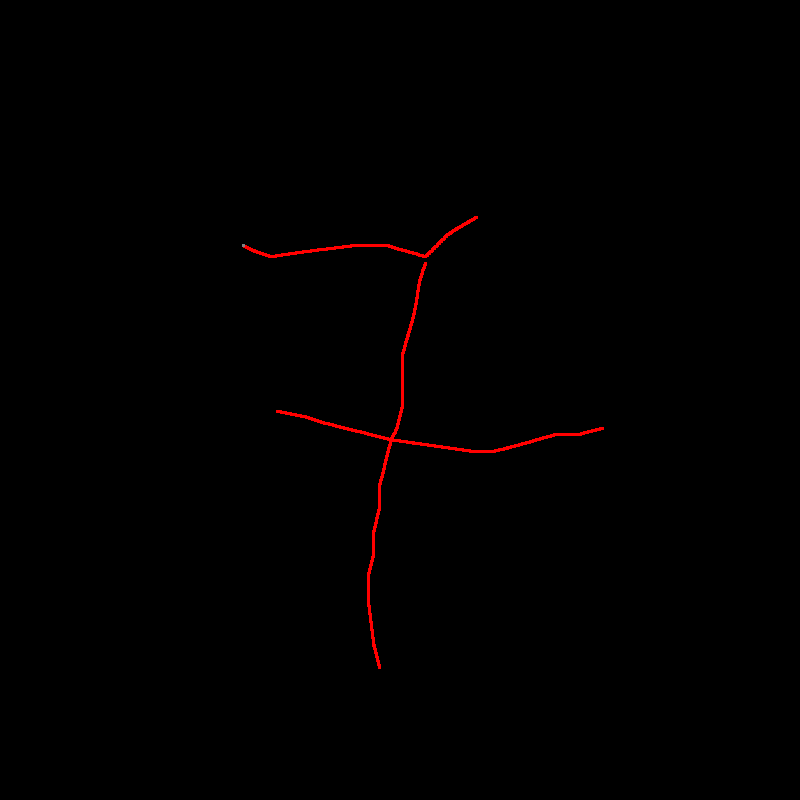

In [409]:
print(engram_image_id)
image_pil = Image.new('L', size=(800, 800), color='black')
image_pil = image_pil.convert('RGB')
draw = ImageDraw.Draw(image_pil)

offset = np.array([image_pil.size[0] // 2, image_pil.size[1] // 2, 0])
mean = np.mean(seq_lv.reshape(-1, 3), axis=0)
mean[-1] = 0

for xy in seq_lv.reshape(-1, 3):
    xy = xy + offset - mean
    draw.rectangle([xy[0] - 1, xy[1] - 1, xy[0] + 1, xy[1] + 1], width=1, fill='red' if xy[2] > 0 else 'gray')

image_pil

In [439]:
sequence = seq

xy_sequence = get_xy_sequence(sequence, si_ind_dict)
vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                 zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T

assert sequence.shape[0] == vec_sequence.shape[0]
assert sequence.shape[0] == vec_len_sequence.shape[0]
assert sequence.shape[0] == norm_vec_sequence.shape[0]

seq_len = vec_len_sequence[vec_len_sequence <= 10].sum() # consider only intraseq 
seq_lv = np.zeros((SEQ_LV_LEN, 3))
assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
k = seq_lv.shape[0] / seq_len

i = 0
i_from = 0
i_to = 0
pt = np.array([0, 0])
    
for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
    if vec_len > 10:
        # interseq jump
        pt = pt + k * norm_vec * vec_len
        continue
    
    if vec_len > 0:
        i += vec_len
        i_to = min(int(i * k), seq_lv.shape[0])
        assert i_from >= 0, i_from
        assert i_to >= i_from, (i_to, i_from)
        assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
        i_to2 = i_to
        
        if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
            i_to2 = seq_lv.shape[0]

        pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T # path interpolation
        seq_lv[i_from:i_to2,0:2] = pts
        seq_lv[i_from:i_to2,2] = 1 # TODO: get rid of
        pt = pts[-1]

    if i_to >= seq_lv.shape[0]:
        # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
        # (i.e. (x2, y2) for such si actually differ). 
        assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))), (si_ind, sequence[-1])
        break

    i_from = i_to


AssertionError: (np.int64(33), np.int64(104))

In [444]:
xy_sequence

array([[ 51, 104],
       [ 55,  98],
       [ 58,  92],
       [ 59,  88],
       [ 61,  81],
       [ 64,  75],
       [ 66,  71],
       [ 67,  67],
       [ 67,  64],
       [ 69,  57],
       [ 70,  52],
       [ 70,  48],
       [ 72,  43],
       [ 73,  38],
       [ 74,  32],
       [ 77,  25],
       [ 49, 104]])

In [443]:
vec_sequence1 = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                 zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
np.linalg.norm(vec_sequence1, axis=1)

array([ 7.21110255,  6.70820393,  4.12310563,  7.28010989,  6.70820393,
        4.47213595,  4.12310563,  3.        ,  7.28010989,  5.09901951,
        4.        ,  5.38516481,  5.09901951,  6.08276253,  7.61577311,
       83.81527307,  2.        ])

In [442]:
vec_len_sequence

array([ 7.21110255,  6.70820393,  4.12310563,  7.28010989,  6.70820393,
        4.47213595,  4.12310563,  3.        ,  7.28010989,  5.09901951,
        4.        ,  5.38516481,  5.09901951,  6.08276253,  7.61577311,
       83.81527307,  0.        ])

In [437]:
sequence

array([ 55, 327,  88, 556, 435,  19, 292, 284, 548, 412, 575, 132, 397,
       383,  33, 566, 104])

In [438]:
si_ind

np.int64(33)

In [440]:
np.any(vec_len_sequence > 10)

np.True_

In [434]:
# %%time
image_ids = RNG.choice(df_train_images.index, 8, replace=False)
images = list(map(lambda image_id: Image.open(io.BytesIO(df_train_images.loc[image_id]['png'])), image_ids))
captions = [f'{image_ids[0]}']

engram_image_id = image_ids[0]
engram_image_id = 58597
matchee_image_ids = image_ids[1:]
matchee_image_id = matchee_image_ids[0]
# matchee_image_id = 5941

###
df_image = df_train_images.loc[engram_image_id]
#
si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
sequences = pickle.loads(df_image['inner_sequences'])

engram_id = next(ENGRAM_ID_SOURCE)
engram = Engram(engram_id=engram_id, image_id=int(engram_image_id), value=df_image['value'], seq_lv_inds=[], si_ind_dict=si_ind_dict)

sequence = get_sequence(sequences) # assemble default sequence

# Phasing (for sequences near to circular) + persisting
for i, si_ind in enumerate(sequence):
    print(i)
    seq = np.roll(sequence, -i, axis=0)
    seq_lv = calc_seq_latent_vector(seq, si_ind_dict)
    # seq_lv_ind = SEQ_LVS.lease()
    # SEQ_LVS.array_active[seq_lv_ind] = phased_seq_lv
    
    seq_lv_ind = SEQ_LVS_COS_SIM.lease()
    SEQ_LVS_COS_SIM.array_active[seq_lv_ind] = seq_lv
    # assert SEQ_LVS_CORR.lease() == seq_lv_ind
    # SEQ_LVS_CORR.array_active[seq_lv_ind] = (phased_seq_lv - phased_seq_lv.mean()) / phased_seq_lv.std()
    assert SEQ_LVS_DIFF_SQ.lease() == seq_lv_ind
    SEQ_LVS_DIFF_SQ.array_active[seq_lv_ind] = np.hstack([seq_lv ** 2, np.full_like(seq_lv, 1, dtype=seq_lv.dtype)])
    
    seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=i, seq=seq, seq_lv_ind=seq_lv_ind)
    SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
    engram.seq_lv_inds.append(seq_lv_ind)

assert False
### 

###
df_image = df_train_images.loc[matchee_image_id]
#
si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
sequences = pickle.loads(df_image['inner_sequences'])
# matchee = Matchee(seqs=[], seq_lvs=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)

# Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
# Count of variants = (seqs_count)! * 2^seqs_count
# seqs_count | variant_counts
# ______________________
# 1          | 2
# 2          | 8
# 3          | 42
# 4          | 384
# 5          | 3840
# 6          | 46080
# 7          | 645120

MAX_SEQUENCES_COUNT = 5

if len(sequences) > MAX_SEQUENCES_COUNT:
    seq_indices = RNG.choice(len(sequences), MAX_SEQUENCES_COUNT, replace=False)
    # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
else:
    seq_indices = list(range(len(sequences)))
    
assert len(seq_indices) <= MAX_SEQUENCES_COUNT

seq_lv_codes = []

for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
    for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
        seq_lv_codes.append(list(zip(perm_seq_indices, seq_orientation)))

for seq_lv_code in seq_lv_codes:
    maps = map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else reversed(sequences[seq_ind_and_orient[0]]), seq_lv_code)
    sequence = np.array(list(itertools.chain.from_iterable(maps)))
    seq_lv = calc_seq_latent_vector(sequence, si_ind_dict)
    # matchee.seq_lvs.append(seq_lv)
    matchee.seq_lvs_cos_sim.append(seq_lv)
    matchee.seq_lvs_diff_sq.append(seq_lv)

matchee = matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))

0
1


AssertionError: (np.int64(33), np.int64(104))

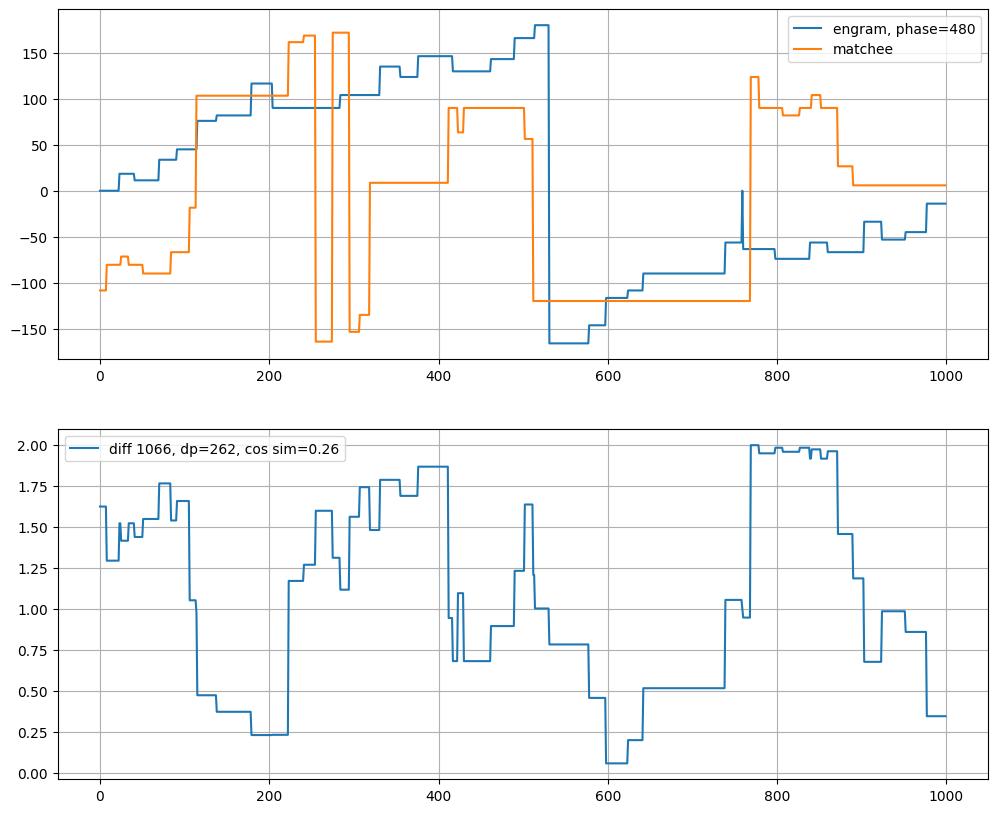

In [17]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)

engram_seq_lv, engram_seq_lv_j = None, None
matchee_seq_lv, matchee_seq_lv_j = None, None

for seq_lv_ind in RNG.choice(engram.seq_lv_inds, 1, replace=False):
    engram_seq_lv = SEQ_LVS.array_active[seq_lv_ind]
    engram_seq_lv_j = engram_seq_lv.reshape(-1, 2)
    engram_seq_lv_j = engram_seq_lv_j[:,0] + 1j * engram_seq_lv_j[:,1]
    plt.plot(np.angle(engram_seq_lv_j, deg=True), label=f'engram, phase={SEQ_LV_IND_TO_META[seq_lv_ind].phase}')

for seq_lv_ind in RNG.choice(matchee.seq_lvs.shape[0], 1, replace=False):
    matchee_seq_lv = matchee.seq_lvs[seq_lv_ind]
    matchee_seq_lv_j = matchee_seq_lv.reshape(-1, 2)
    matchee_seq_lv_j = matchee_seq_lv_j[:,0] + 1j * matchee_seq_lv_j[:,1]
    plt.plot(np.angle(matchee_seq_lv_j, deg=True), label=f'matchee')

plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
diff = np.sum(np.absolute(engram_seq_lv_j - matchee_seq_lv_j))
dp = engram_seq_lv @ matchee_seq_lv
plt.plot(np.absolute(engram_seq_lv_j - matchee_seq_lv_j), label=f'diff {diff:.0f}, dp={dp:0.0f}, cos sim={dp / SEQ_LV_LEN:.2f}')
plt.grid()
plt.legend()

plt.show()

# Train

In [449]:
TRAIN_RUNS_COUNT = 0
TRAIN_IMAGES_COUNT = 0
clear_memory()

# MATCH_TAB_METHOD = 'cos_sim'

In [450]:
image_id

58597

In [451]:
# %%time
train_runs = 1
count = min(1000, len(df_train_images))

for _ in tqdm(range(train_runs)):
    TRAIN_RUNS_COUNT += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    # image_ids = [58597]
    # image_ids = [21613]
    # image_ids = image_ids[0:1]

    for image_id in tqdm(image_ids, leave=False):
        TRAIN_IMAGES_COUNT += 1
        df_image = df_train_images.loc[image_id]
        image_value = df_image['value']
        matchee = create_matchee(df_image)
        df_match_tab = get_match_tab(matchee)
        
        if len(df_match_tab) > 0:
            if df_match_tab.iloc[0]['engram_value'] == image_value:
                continue

        engram = create_engram(df_image)
        ENGRAMS[engram.engram_id] = engram
        print(f'New engram for {image_id:5} {image_value} {len(ENGRAMS)}')

    print(f'Total engrams {len(ENGRAMS)}')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

New engram for  7271 0 1
New engram for 58597 1 2
New engram for 37376 9 3
New engram for  4302 5 4
New engram for  5941 3 5
New engram for 41035 8 6
New engram for 53171 7 7
New engram for 45849 8 8
New engram for 18702 6 9
New engram for  2317 4 10
New engram for 13567 3 11
New engram for  5366 4 12
New engram for 54315 2 13
New engram for 57366 2 14
New engram for 41232 7 15
New engram for  3512 8 16
New engram for 21297 9 17
New engram for 29322 9 18
New engram for 38137 9 19
New engram for  4596 5 20
New engram for 39577 6 21
New engram for  2805 8 22
New engram for 35386 1 23
New engram for 25260 4 24
New engram for  7966 3 25
New engram for 39777 6 26
New engram for  7965 4 27
New engram for 33748 5 28
New engram for 11364 2 29
New engram for 35135 9 30
New engram for  9945 5 31
New engram for 27536 6 32
New engram for 43990 7 33
New engram for 33578 0 34
New engram for 13548 4 35
New engram for  7745 3 36
New engram for  8649 5 37
New engram for 44153 4 38
New engram for 50992 

## .lab

In [467]:
list(map(lambda kv: kv[1].image_id, filter(lambda kv: kv[1].value == '6', ENGRAMS.items())))

[18702, 39577, 39777, 27536]

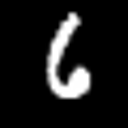

In [473]:
# %%time
image_id = RNG.choice(df_train_images.index)
image_id = 39577
image = Image.open(io.BytesIO(df_train_images.loc[image_id]['png']))
matchee = create_matchee(df_train_images.loc[image_id])
image

In [72]:
%%time
method = 'diff_sq'
inspect_depth = 100

match_tab_columns = defaultdict(list)
dot_prod_mat = (SEQ_LVS_COS_SIM.array_active @ matchee.seq_lvs_cos_sim.T)
cos_sim_mat = dot_prod_mat / (-SEQ_LV_LEN)
corr_mat = (SEQ_LVS_CORR.array_active @ matchee.seq_lvs_corr.T) / (-SEQ_LVS_CORR.array_active.shape[1])
diff_sq_mat = (SEQ_LVS_DIFF_SQ.array_active @ matchee.seq_lvs_diff_sq.T) - dot_prod_mat - dot_prod_mat

mat = {
    'cos_sim': cos_sim_mat,
    'corr': corr_mat,
    'diff_sq': diff_sq_mat
}[method]
top_mat_indices = np.argsort(mat, axis=None)[:inspect_depth] 

for top_mat_index in top_mat_indices:
    i = top_mat_index // mat.shape[1]
    j = top_mat_index % mat.shape[1]
    seq_lv_meta = SEQ_LV_IND_TO_META[i]
    engram = ENGRAMS[seq_lv_meta.engram_id]
    match_tab_columns['engram_seq_lv_ind'].append(i)
    match_tab_columns['matchee_seq_lv_ind'].append(j)
    match_tab_columns['cos_sim'].append(-cos_sim_mat[i,j])
    match_tab_columns['corr'].append(-corr_mat[i,j])
    match_tab_columns['diff_sq'].append(diff_sq_mat[i,j])  
    match_tab_columns['engram_id'].append(engram.engram_id)
    match_tab_columns['engram_value'].append(engram.value)
    match_tab_columns['engram_image_id'].append(engram.image_id)  
    match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
    match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])

df_match_tab = pd.DataFrame(match_tab_columns)
df_match_tab.head(10)

CPU times: user 179 ms, sys: 0 ns, total: 179 ms
Wall time: 16.4 ms


,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,corr,diff_sq,engram_id,engram_value,engram_image_id,engram_phase,matchee_seq_lv_code
0,1103,0,1.000000,1.000000,0.000000,226,8,45849,0,"((0, 0),)"
1,1160,0,0.912597,0.912596,174.806798,226,8,45849,1966,"((0, 0),)"
2,1104,0,0.905643,0.905643,188.713953,226,8,45849,36,"((0, 0),)"
3,417,0,0.812895,0.812895,374.210178,208,3,9294,934,"((0, 0),)"
4,418,0,0.804750,0.804750,390.499760,208,3,9294,966,"((0, 0),)"
5,568,1,0.782512,0.782512,434.975511,212,7,43990,468,"((0, 1),)"
6,416,0,0.775087,0.775087,449.825408,208,3,9294,898,"((0, 0),)"
7,1159,0,0.764358,0.764358,471.283260,226,8,45849,1926,"((0, 0),)"
8,1105,0,0.764358,0.764358,471.283260,226,8,45849,74,"((0, 0),)"
9,567,1,0.740837,0.740837,518.326281,212,7,43990,398,"((0, 1),)"


In [22]:
# df_match_tab.sort_values(by=['diff'], inplace=True, ignore_index=True)
# df_match_tab.head(10)

[]

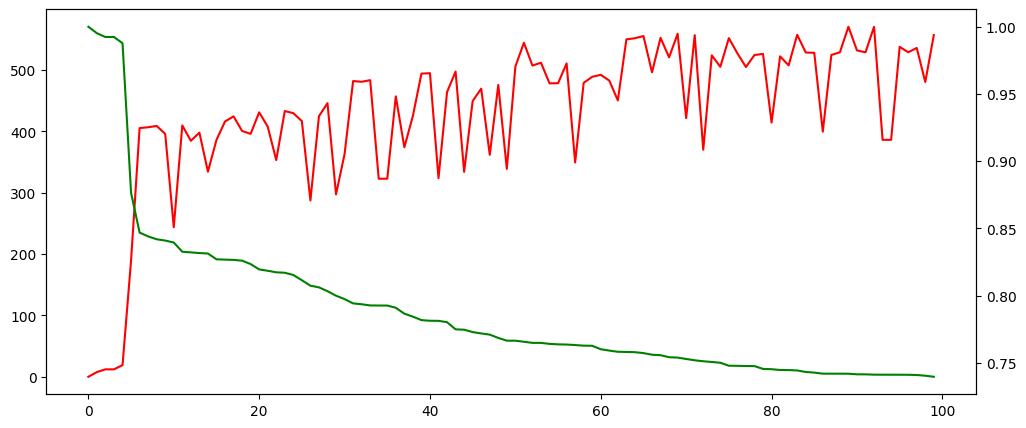

In [23]:
plt.figure(figsize=(12, 5))

plt.plot(df_match_tab.index, df_match_tab['diff'], c='r', label='diff')
ax2 = plt.gca().twinx()
ax2.plot(df_match_tab.index, df_match_tab['cos_sim'], c='g', label='cos_sim')
plt.plot()

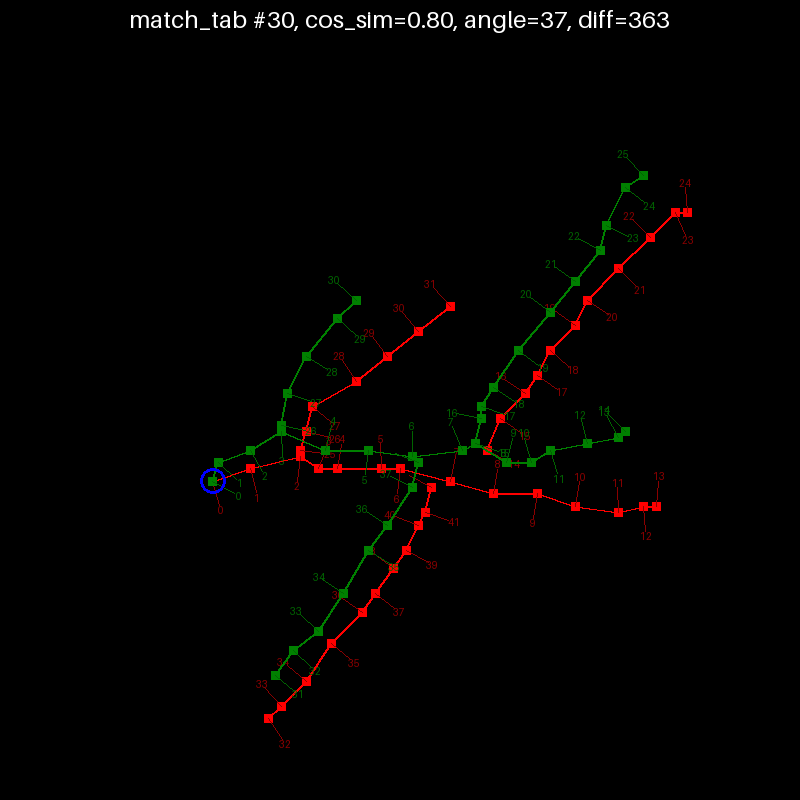

In [24]:
image_pil = Image.new('L', size=(800, 800), color='black')
image_pil = image_pil.convert('RGB')
k = image_pil.size[0] / config.sample_size
draw = ImageDraw.Draw(image_pil)

match_tab_row_index = RNG.choice(len(df_match_tab))
df_match_tab_row = df_match_tab.iloc[match_tab_row_index]

matchee_seq_lv_ind = df_match_tab_row['matchee_seq_lv_ind']
matchee_seq = matchee.seqs[matchee_seq_lv_ind]
matchee_xy_seq = get_xy_sequence(matchee_seq, matchee.si_ind_dict)
matchee_pt_xy = matchee_xy_seq[0]

engram = ENGRAMS[df_match_tab_row['engram_id']]
engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
engram_seq_lv_meta = SEQ_LV_IND_TO_META[engram_seq_lv_ind]
engram_seq = engram_seq_lv_meta.seq
engram_xy_seq = get_xy_sequence(engram_seq, engram.si_ind_dict)

assert engram_seq.shape[0] == engram_xy_seq.shape[0]

engram_xy_seq = engram_xy_seq - engram_xy_seq[0] + matchee_pt_xy
engram_si_serial_to_xy = {}

for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(engram_xy_seq, engram_xy_seq[1:]), zip(engram_seq, engram_seq[1:]))):
    pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
    pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
    
    vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]

    if np.linalg.norm(vec) < 10:
        draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='red')
        
    draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='red')
    draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='red')

    si_from = engram.si_ind_dict[seq_row[0]]
    si_to = engram.si_ind_dict[seq_row[1]]
    nl = 4 * k
    normal_vec = si_from.normal_vec
    draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
    draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')

    normal_vec = si_to.normal_vec
    draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
    # draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')
    
    engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
    engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])

matchee_si_serial_to_xy = {}

for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(matchee_xy_seq, matchee_xy_seq[1:]), zip(matchee_seq, matchee_seq[1:]))):
    pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
    pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
    vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
    # color = 'red' if np.linalg.norm(vec) < 10 else 'gray'

    if np.linalg.norm(vec) < 10:
        draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='green')
        
    draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='green')
    draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='green')

    si_from = matchee.si_ind_dict[seq_row[0]]
    si_to = matchee.si_ind_dict[seq_row[1]]
    nl = 4 * k
    normal_vec = si_from.normal_vec
    draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
    draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkgreen')

    normal_vec = si_to.normal_vec
    draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
    # draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')
    
    matchee_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
    matchee_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])

draw.circle((k * matchee_pt_xy[0], k * matchee_pt_xy[1]), radius=k*2, outline='blue', width=3)

draw.text((image_pil.size[0] / 2, 10), f'match_tab #{match_tab_row_index}, cos_sim={df_match_tab_row['cos_sim']:.2f}, angle={np.rad2deg(np.arccos(df_match_tab_row['cos_sim'])):.0f}, diff={df_match_tab_row['diff']:.0f}', font_size=24, anchor='mt')
image_pil

# Test

In [454]:
%%time
test_results_db_con.cursor().execute('INSERT INTO test_runs(dummy) VALUES(1)')
test_run_id = test_results_db_con.cursor().execute('SELECT MAX(test_run_id) FROM test_runs').fetchone()[0]
test_run_source = {
    'test': (df_test_images, test_db_con, 'test'),
    'train': (df_train_images, train_db_con, 'train')
}['test']
count = min(200, len(test_run_source[0]))
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
# test_image_ids = [100004526]
# test_image_ids = image_ids
test_result_rows = defaultdict(list)
match_tabs = []

for image_id in tqdm(test_image_ids):
    df_image = test_run_source[0].loc[image_id]
    image_value = df_image['value']
    matchee = create_matchee(df_image)
    # df_match_tab = get_match_tab(matchee, compute_diff=False)
    df_match_tab = get_match_tab(matchee)
    df_match_tab['test_image_id'] = image_id
    df_match_tab['true_value'] = image_value
    match_tabs.append(df_match_tab)
    
    # infer_value, engram_image_id, cos_sim, corr, diff_sq = ('', -1, 0, 0, 9999)
    infer_value, engram_image_id, cos_sim, diff_sq = ('', -1, 0, 9999)
        
    if len(df_match_tab) > 0:
        # infer_value, engram_image_id, cos_sim, corr, diff_sq = df_match_tab.iloc[0][['engram_value', 'engram_image_id', 'cos_sim', 'corr', 'diff_sq']]
        infer_value, engram_image_id, cos_sim, diff_sq = df_match_tab.iloc[0][['engram_value', 'engram_image_id', 'cos_sim', 'diff_sq']]
    
    test_result_rows['test_run_id'].append(test_run_id)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append(f'[{','.join([])}]')
    test_result_rows['train_images_count'].append(TRAIN_IMAGES_COUNT)
    test_result_rows['train_runs_count'].append(TRAIN_RUNS_COUNT)
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['engram_image_id'].append(engram_image_id)
    test_result_rows['infer_value'].append(infer_value)
    test_result_rows['cos_sim'].append(cos_sim)
    # test_result_rows['corr'].append(corr)
    test_result_rows['diff_sq'].append(diff_sq)
    test_result_rows['match_tab_method'].append(MATCH_TAB_METHOD)
    test_result_rows['match_tab_index'].append(len(match_tabs) - 1)


df_test_results_for_run = pd.DataFrame(test_result_rows)
DBUtils.ensure_table_columns(test_results_db_con, 'test_results', list(df_test_results_for_run.columns))
df_test_results_for_run.to_sql(name='test_results', con=test_results_db_con, if_exists='append')
pd.DataFrame({'test_run_id': [test_run_id], 'match_tabs': [pickle.dumps(match_tabs)]}).to_sql(name='test_run_artifacts', con=test_results_db_con, if_exists='append');

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 11.9 s, sys: 14.8 ms, total: 11.9 s
Wall time: 1.35 s


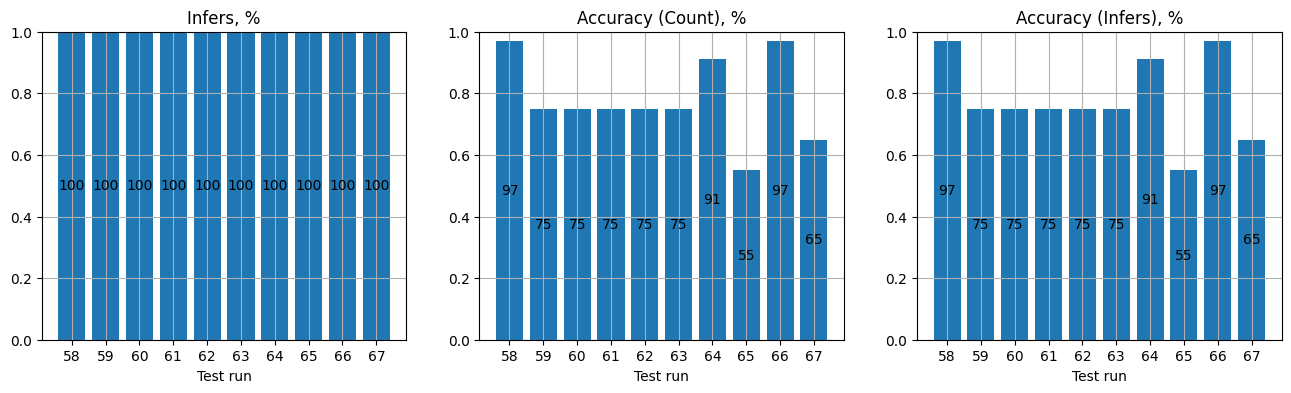

,config_variant,source_ds,cortical_columns,train_images_count,train_runs_count,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,,
58,SQLITE3_SEQ_GRID_0_2_4096,train,[],100,1,100,100,97,1.0,0.97,0.97
59,SQLITE3_SEQ_GRID_0_2_4096,test,[],100,1,20,20,15,1.0,0.75,0.75
60,SQLITE3_SEQ_GRID_0_2_4096,test,[],100,1,20,20,15,1.0,0.75,0.75
61,SQLITE3_SEQ_GRID_0_2_4096,test,[],200,2,20,20,15,1.0,0.75,0.75
62,SQLITE3_SEQ_GRID_0_2_4096,test,[],200,2,20,20,15,1.0,0.75,0.75
63,SQLITE3_SEQ_GRID_0_2_4096,test,[],300,3,20,20,15,1.0,0.75,0.75
64,SQLITE3_SEQ_GRID_0_2_4096,train,[],100,1,100,100,91,1.0,0.91,0.91
65,SQLITE3_SEQ_GRID_0_2_4096,test,[],100,1,20,20,11,1.0,0.55,0.55
66,SQLITE3_SEQ_GRID_0_2_4096,train,[],100,1,100,100,97,1.0,0.97,0.97


In [455]:
df_test_results2 = pd.read_sql_query('''
SELECT * FROM test_results 
WHERE test_run_id IN (SELECT test_run_id FROM test_runs ORDER BY test_run_id DESC LIMIT 10)
ORDER BY test_run_id ASC
''', con=test_results_db_con)
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs_count': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

## analyze

In [456]:
df_incorrect = df_test_results_for_run.loc[df_test_results_for_run.true_value != df_test_results_for_run.infer_value]
# df_incorrect[['test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'cos_sim', 'corr', 'diff_sq', 'match_tab_index', 'match_tab_method']]
df_incorrect[['test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'cos_sim', 'diff_sq', 'match_tab_index', 'match_tab_method']]

,test_image_id,true_value,engram_image_id,infer_value,cos_sim,diff_sq,match_tab_index,match_tab_method
1,100004627,6,33578,0,-1,1.073831e+07,1,cos_sim
3,100003117,5,41035,8,-1,7.571817e+06,3,cos_sim
6,100005039,4,35135,9,-1,2.266300e+06,6,cos_sim
10,100002350,2,27536,6,-1,5.534504e+06,10,cos_sim
14,100005854,7,35135,9,-1,3.780020e+06,14,cos_sim
15,100003769,3,53171,7,-1,7.172557e+06,15,cos_sim
17,100002995,6,33578,0,-1,4.947439e+06,17,cos_sim


In [457]:
df_correct = df_test_results_for_run.loc[df_test_results_for_run.true_value == df_test_results_for_run.infer_value].copy()
# df_correct[['test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'cos_sim', 'corr', 'diff_sq', 'match_tab_index']]
df_correct[['test_image_id', 'true_value', 'engram_image_id', 'infer_value', 'cos_sim', 'diff_sq', 'match_tab_index', 'match_tab_method']]

,test_image_id,true_value,engram_image_id,infer_value,cos_sim,diff_sq,match_tab_index,match_tab_method
0,100004526,3,7966,3,-1,3.923883e+06,0,cos_sim
2,100003413,0,7271,0,-1,2.701706e+06,2,cos_sim
4,100000942,6,18702,6,-1,7.296056e+06,4,cos_sim
5,100007399,1,58597,1,-1,1.092446e+07,5,cos_sim
7,100003216,8,34946,8,-1,5.170115e+06,7,cos_sim
8,100006251,4,7965,4,-1,6.921728e+06,8,cos_sim
9,100007120,2,11364,2,-1,1.056435e+07,9,cos_sim
11,100008600,1,58597,1,-1,1.890545e+06,11,cos_sim
12,100003425,7,43990,7,-1,6.521688e+06,12,cos_sim
13,100006640,7,43990,7,-1,1.809028e+06,13,cos_sim


In [458]:
match_tab_index = 1
match_tabs[match_tab_index].head(20)

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,diff_sq,engram_id,engram_value,engram_image_id,engram_phase,matchee_seq_lv_code,test_image_id,true_value
0,1288,2,-1,1.073831e+07,639,0,33578,12,"((0, 1), (1, 0))",100004627,6
1,1289,2,-1,1.104440e+07,639,0,33578,13,"((0, 1), (1, 0))",100004627,6
2,1288,3,-1,1.116365e+07,639,0,33578,12,"((0, 1), (1, 1))",100004627,6
3,1289,3,-1,1.143774e+07,639,0,33578,13,"((0, 1), (1, 1))",100004627,6
4,1287,2,-1,1.281289e+07,639,0,33578,11,"((0, 1), (1, 0))",100004627,6
5,1287,3,-1,1.328649e+07,639,0,33578,11,"((0, 1), (1, 1))",100004627,6
6,1290,2,-1,1.465760e+07,639,0,33578,14,"((0, 1), (1, 0))",100004627,6
7,1290,3,-1,1.502743e+07,639,0,33578,14,"((0, 1), (1, 1))",100004627,6
8,1225,2,-1,1.593618e+07,637,6,27536,18,"((0, 1), (1, 0))",100004627,6
9,1226,2,-1,1.597457e+07,637,6,27536,19,"((0, 1), (1, 0))",100004627,6


In [525]:
match_tabs[match_tab_index][match_tabs[match_tab_index]['engram_image_id'] == 39577]
# 50992

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,diff_sq,engram_id,engram_value,engram_image_id,engram_phase,matchee_seq_lv_code,test_image_id,true_value
31,803,1,-1,1.960089e+07,626,6,39577,1,"((0, 0), (1, 1))",100004627,6
33,803,0,-1,1.979008e+07,626,6,39577,1,"((0, 0), (1, 0))",100004627,6
35,802,1,-1,1.995920e+07,626,6,39577,0,"((0, 0), (1, 1))",100004627,6
37,802,0,-1,2.013803e+07,626,6,39577,0,"((0, 0), (1, 0))",100004627,6
40,804,1,-1,2.081087e+07,626,6,39577,2,"((0, 0), (1, 1))",100004627,6
42,804,0,-1,2.283044e+07,626,6,39577,2,"((0, 0), (1, 0))",100004627,6
90,805,1,-1,2.610668e+07,626,6,39577,3,"((0, 0), (1, 1))",100004627,6


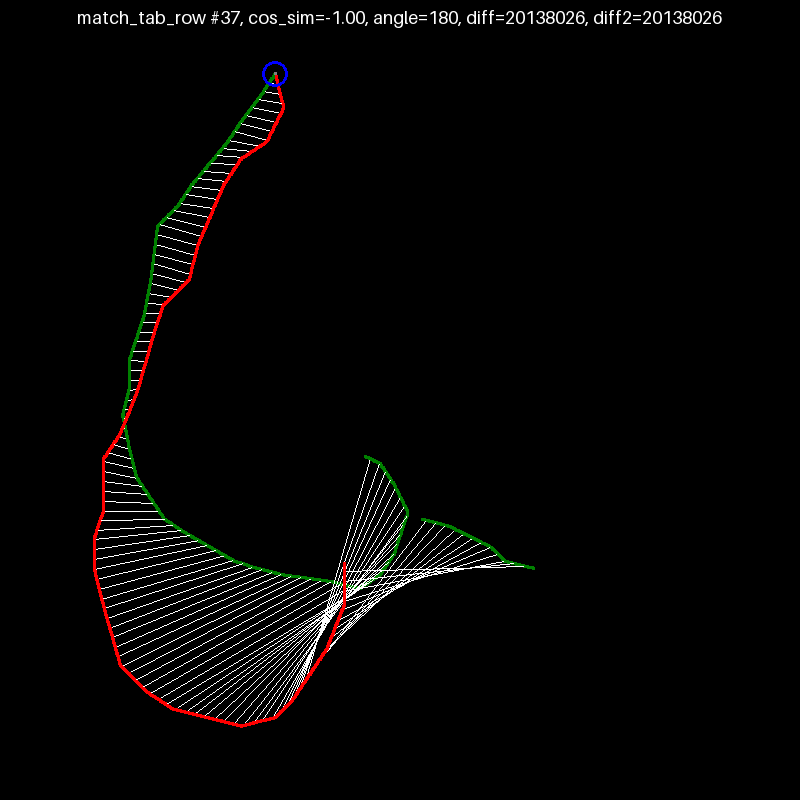

In [527]:
render_match_tab_row(mt.iloc[37], matchee, use_seq_lv=True) # 1324

In [485]:
mt = get_match_tab(matchee, inspect_depth=9999999)
# mt[(mt['engram_image_id'] == 39577) & (mt['matchee_seq_lv_code'] == ((1,0), (2,0), (3,0), (0,0)))]
mt[(mt['engram_image_id'] == 39577) & (mt['matchee_seq_lv_code'] == ((0,0), (1,0)))]

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,diff_sq,engram_id,engram_value,engram_image_id,engram_phase,matchee_seq_lv_code
33,803,0,-1,1.979008e+07,626,6,39577,1,"((0, 0), (1, 0))"
37,802,0,-1,2.013803e+07,626,6,39577,0,"((0, 0), (1, 0))"
42,804,0,-1,2.283044e+07,626,6,39577,2,"((0, 0), (1, 0))"
111,805,0,-1,2.823946e+07,626,6,39577,3,"((0, 0), (1, 0))"
219,806,0,-1,3.571417e+07,626,6,39577,4,"((0, 0), (1, 0))"
647,807,0,-1,5.271168e+07,626,6,39577,5,"((0, 0), (1, 0))"
2142,808,0,-1,7.835543e+07,626,6,39577,6,"((0, 0), (1, 0))"
4106,809,0,-1,1.010567e+08,626,6,39577,7,"((0, 0), (1, 0))"
6021,810,0,-1,1.245702e+08,626,6,39577,8,"((0, 0), (1, 0))"
9456,811,0,-1,1.769416e+08,626,6,39577,9,"((0, 0), (1, 0))"


In [466]:
np.sum((engram_seq_lv.reshape(-1, 3)[-30:] - matchee_seq_lv.reshape(-1, 3)[-30:]) ** 2)

np.float64(1410297.8511858142)

In [462]:
engram_seq_lv.reshape(-1, 3)[-30:]

array([[-13.18265066, -51.46249975,   1.        ],
       [-12.90792954, -50.5009758 ,   1.        ],
       [-12.63320841, -49.53945185,   1.        ],
       [-12.35848728, -48.57792791,   1.        ],
       [-12.08376615, -47.61640396,   1.        ],
       [-11.80904502, -46.65488001,   1.        ],
       [-11.5343239 , -45.69335606,   1.        ],
       [-11.25960277, -44.73183212,   1.        ],
       [-10.98488164, -43.77030817,   1.        ],
       [-10.71016051, -42.80878422,   1.        ],
       [-10.43543938, -41.84726027,   1.        ],
       [-10.16071826, -40.88573633,   1.        ],
       [ -9.88599713, -39.92421238,   1.        ],
       [ -9.611276  , -38.96268843,   1.        ],
       [ -9.33655487, -38.00116448,   1.        ],
       [ -9.06183375, -37.03964053,   1.        ],
       [ -8.78711262, -36.07811659,   1.        ],
       [ -8.51239149, -35.11659264,   1.        ],
       [ -8.23767036, -34.15506869,   1.        ],
       [ -7.96294923, -33.19354

In [463]:
matchee_seq_lv.reshape(-1, 3)[-30:]

array([[138.18703598, 103.41975585,   1.        ],
       [139.15717848, 103.66229147,   1.        ],
       [140.12732098, 103.9048271 ,   1.        ],
       [141.09746348, 104.14736272,   1.        ],
       [142.06760598, 104.38989835,   1.        ],
       [143.03774848, 104.63243397,   1.        ],
       [144.00789098, 104.8749696 ,   1.        ],
       [144.97803348, 105.11750522,   1.        ],
       [145.94817598, 105.36004085,   1.        ],
       [146.91831848, 105.60257647,   1.        ],
       [147.88846098, 105.8451121 ,   1.        ],
       [148.85860348, 106.08764772,   1.        ],
       [149.82874598, 106.33018335,   1.        ],
       [150.79888848, 106.57271897,   1.        ],
       [151.76903098, 106.8152546 ,   1.        ],
       [152.73917348, 107.05779022,   1.        ],
       [153.70931598, 107.30032585,   1.        ],
       [154.67945848, 107.54286147,   1.        ],
       [155.64960098, 107.7853971 ,   1.        ],
       [156.61974348, 108.02793

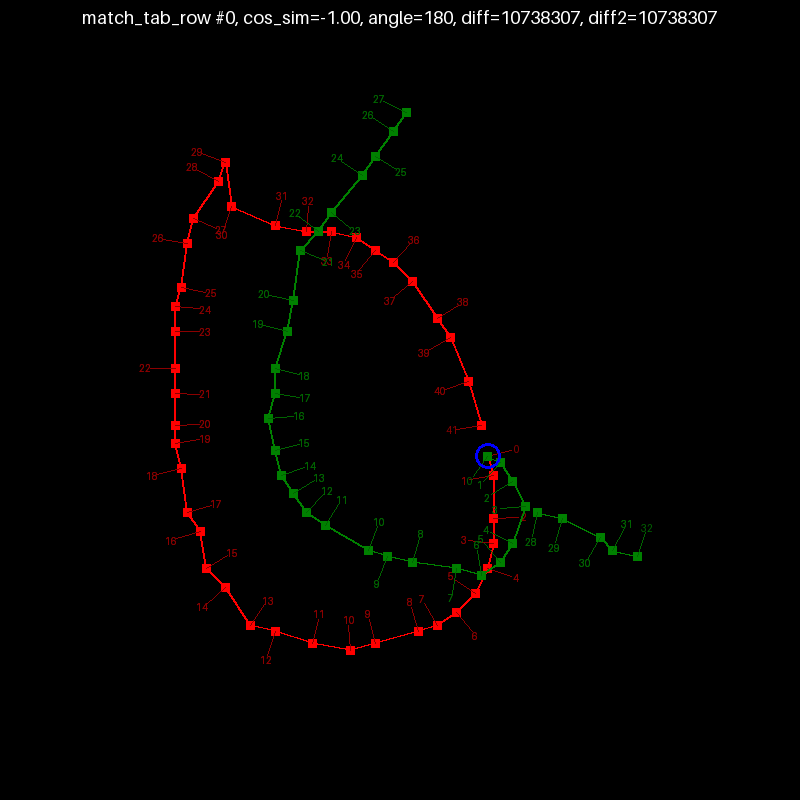

In [484]:
df_match_tab_row = match_tabs[match_tab_index].iloc[0]
test_image_id = df_match_tab_row['test_image_id']

if test_image_id >= 100_000_000:
    df_test_image = df_test_images.loc[test_image_id]
else:
    df_test_image = df_train_images.loc[test_image_id]

# matchee = create_matchee(df_test_image, df_match_tab_row['matchee_seq_lv_code'])
matchee = create_matchee(df_test_image)

engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
engram_seq_lv = SEQ_LVS_COS_SIM.array_active[df_match_tab_row['engram_seq_lv_ind']]

matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]

render_match_tab_row(df_match_tab_row, matchee)

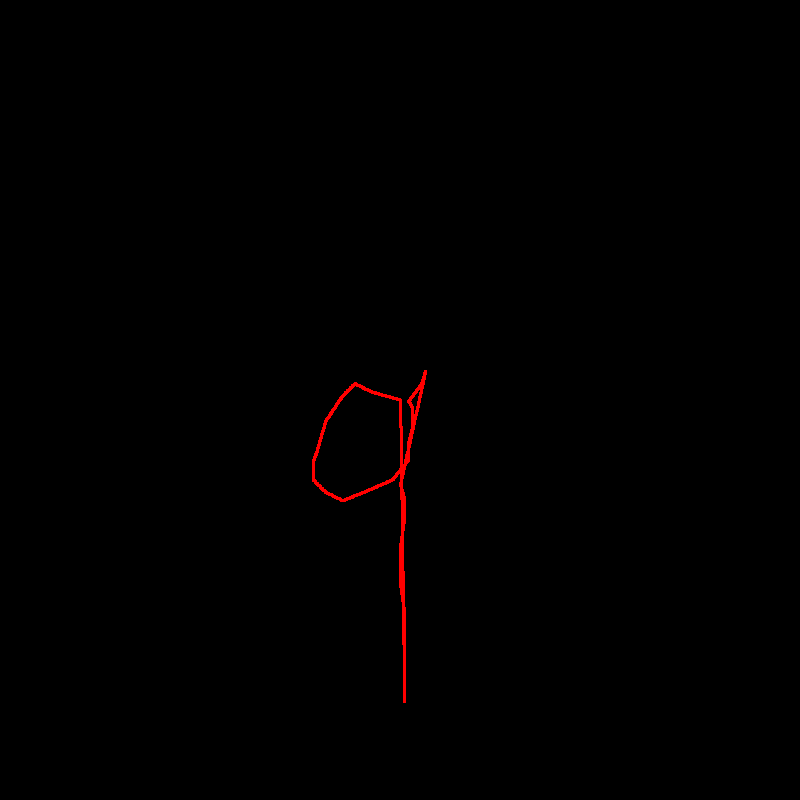

In [96]:
image_pil = Image.new('L', size=(800, 800), color='black')
image_pil = image_pil.convert('RGB')
k = image_pil.size[0] / config.sample_size
draw = ImageDraw.Draw(image_pil)

xy_from = np.array([image_pil.size[0] // 2, image_pil.size[1] // 2, 0])

seq_lv = engram_seq_lv
seq_lv = matchee_seq_lv

for vec in seq_lv.reshape(-1, 3):
    xy_to = xy_from + vec
    pt_from = xy_from[0], xy_from[1] 
    pt_to = xy_to[0], xy_to[1]
    # print(xy_from, xy_to, pt_from, pt_to)
    
    vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]

    if np.linalg.norm(vec) < 10:
        draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=2, fill='red')
        
    draw.rectangle([pt_from[0] - 1, pt_from[1] - 1, pt_from[0] + 1, pt_from[1] + 1], width=1, fill='red')
    draw.rectangle([pt_to[0] - 1, pt_to[1] - 1, pt_to[0] + 1, pt_to[1] + 1], width=1, fill='red')

    xy_from = xy_to

image_pil

In [199]:
SEQ_LV_IND_TO_META[engram_seq_lv_ind].seq

array([ 696,  977, 1089, 1051,  816,  303,  228,  268,  168,  378,  800,
        872,   57,  295, 1077, 1152, 1102,  467,  339,  333,  545,  533,
        657, 1108,  133,   16,   82,  163,  914,  790,  770,  730,  586,
        252, 1024,  574])

In [195]:
engram_seq_lv[-120:].reshape(-1, 3)

array([[-0.31622777, -0.9486833 ,  1.        ],
       [-0.31622777, -0.9486833 ,  1.        ],
       [-0.31622777, -0.9486833 ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.        ],
       [ 0.        , -1.        ,  1.   

In [196]:
matchee_seq_lv[-120:].reshape(-1, 3)

array([[ 0.62469505, -0.78086881,  1.        ],
       [ 0.62469505, -0.78086881,  1.        ],
       [ 0.62469505, -0.78086881,  1.        ],
       [ 0.62469505, -0.78086881,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.        ],
       [ 0.24253563, -0.9701425 ,  1.   

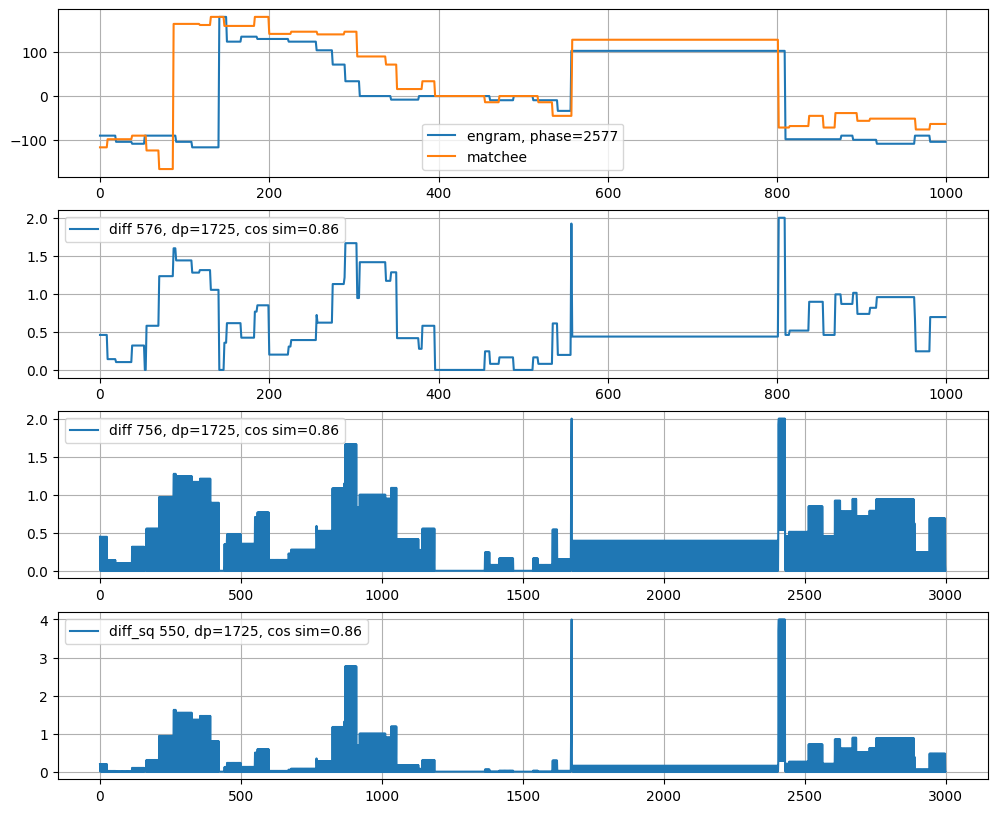

In [194]:
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)

engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
engram_seq_lv = SEQ_LVS_COS_SIM.array_active[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv_j = engram_seq_lv.reshape(-1, 3)
engram_seq_lv_j = engram_seq_lv_j[:,0] + 1j * engram_seq_lv_j[:,1]
plt.plot(np.angle(engram_seq_lv_j, deg=True), label=f'engram, phase={SEQ_LV_IND_TO_META[engram_seq_lv_ind].phase}')

matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]
matchee_seq_lv_j = matchee_seq_lv.reshape(-1, 3)
matchee_seq_lv_j = matchee_seq_lv_j[:,0] + 1j * matchee_seq_lv_j[:,1]
plt.plot(np.angle(matchee_seq_lv_j, deg=True), label=f'matchee')

plt.grid()
plt.legend()

dp = engram_seq_lv @ matchee_seq_lv
cos_sim = dp / (2 * SEQ_LV_LEN)

plt.subplot(4, 1, 2)
diff = np.sum(np.absolute(engram_seq_lv_j - matchee_seq_lv_j))
plt.plot(np.absolute(engram_seq_lv_j - matchee_seq_lv_j), label=f'diff {diff:.0f}, dp={dp:0.0f}, cos sim={cos_sim:.2f}')
plt.grid()
plt.legend()

plt.subplot(4, 1, 3)
diff = np.sum(np.absolute(engram_seq_lv - matchee_seq_lv))
plt.plot(np.absolute(engram_seq_lv - matchee_seq_lv), label=f'diff {diff:.0f}, dp={dp:0.0f}, cos sim={cos_sim:.2f}')
plt.grid()
plt.legend()

plt.subplot(4, 1, 4)
diff_sq = np.sum((engram_seq_lv - matchee_seq_lv) ** 2)
plt.plot((engram_seq_lv - matchee_seq_lv) ** 2, label=f'diff_sq {diff_sq:.0f}, dp={dp:0.0f}, cos sim={cos_sim:.2f}')
plt.grid()
plt.legend()

plt.show()

In [96]:
engram_seq_lv[50:70]

array([ 0.89442719, -0.4472136 ,  0.89442719, -0.4472136 ,  0.89442719,
       -0.4472136 ,  0.89442719, -0.4472136 ,  0.89442719, -0.4472136 ,
        0.89442719, -0.4472136 ,  0.89442719, -0.4472136 ,  0.89442719,
       -0.4472136 ,  0.89442719, -0.4472136 ,  0.89442719, -0.4472136 ])

In [97]:
matchee_seq_lv[50:70]

array([ 0.70710678, -0.70710678,  0.70710678, -0.70710678,  0.86824314,
       -0.49613894,  0.86824314, -0.49613894,  0.86824314, -0.49613894,
        0.86824314, -0.49613894,  0.86824314, -0.49613894,  0.86824314,
       -0.49613894,  0.86824314, -0.49613894,  0.86824314, -0.49613894])

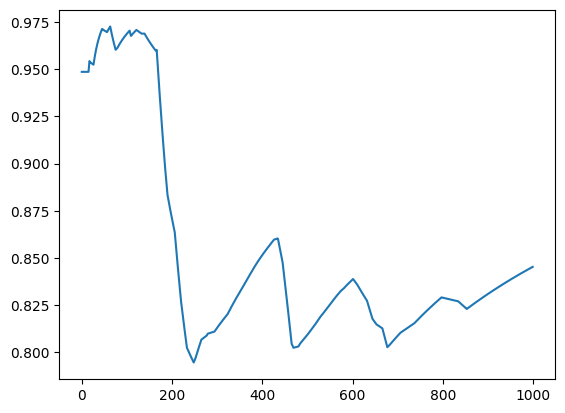

In [115]:
cos_sims = []

for vec_len in range(1, SEQ_LV_LEN + 1):
    dp = engram_seq_lv[:vec_len*2] @ matchee_seq_lv[:vec_len*2]
    cos_sim = dp / vec_len
    cos_sims.append(cos_sim)

plt.plot(list(range(SEQ_LV_LEN)), cos_sims)
plt.show()

In [128]:
engram_seq_lv.mean()

np.float64(-0.00011418367845166699)

In [130]:
v1 = engram_seq_lv - engram_seq_lv.mean()
v2 = matchee_seq_lv - matchee_seq_lv.mean()

In [135]:
v1 @ v2 / v1.shape, np.sqrt(v1 @ v2 / v1.shape)

(array([0.42260561]), array([0.65008123]))

In [133]:
v1.shape

(2000,)

In [132]:
np.linalg.norm(engram_seq_lv)

np.float64(31.622776601683793)